In [1]:
import zarr
import xarray as xr
import matplotlib.pyplot as plt
import gzip
import pickle
import numpy as np

In [2]:
######################## workaround not having data ###########################################
%matplotlib notebook

lat1=14
lat2=18
lon1=36
lon2=40

common=xr.open_zarr("/home/scratch/Abel_data/long_run2/common",consolidated=False)
lat=np.radians(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

st=0
temp_field=0
for i in range(1,51):
    for j in range(1,21):
        D=xr.open_zarr("/home/scratch/Abel_data/long_run2/run"+str(i)+"/year"+str(j),consolidated=False)
        if st==0:
            temp_field=D['air_temperature'][:,0].sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
            st=1
        elif st==1:
            temp_field = np.concatenate((temp_field, 
                                         D['air_temperature'][:,0].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))), axis=0)

mean=np.mean(temp_field, axis=0)

obs=(temp_field*np.cos(lat)).sum(axis=(1,2))/(np.cos(lat).sum())
obs70=np.quantile(obs,0.95)
obs95=np.quantile(obs,0.95)
mean=np.mean(obs)
print(mean)
print(obs95-mean)
print(obs70,obs95)

heat_count=0
heat_index=[]

for i in range(1,51):
    for j in range(1,21):
        
        D=xr.open_zarr("/home/scratch/Abel_data/long_run2/run"+str(i)+"/year"+str(j),consolidated=False)
        temp_field=D['air_temperature'][:,0].sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
        obs=(temp_field*np.cos(lat)).sum(axis=(1,2))/(np.cos(lat).sum())
        
        ind=[]
        l=0
        ind_curr=[]
        int_heat=[]

        for k in range(365):
            
            if obs[k]>obs70:
                if len(ind_curr)==0:
                    ind_curr.append(k-1)
                    int_heat.append(obs[k-1])
                ind_curr.append(k)
                int_heat.append(obs[k])
                if obs[k]>obs95:
                    l=l+1
                else:
                    if l<3:
                        l=0
                        
            else:
                if l>=3:
                    ind_curr.append(k)
                    int_heat.append(obs[k])
#                     print(len(ind_curr))
                    
                    heat=np.array(int_heat)-obs95
                    st=1-heat[0]/(heat[0]-heat[1]); end=heat[-2]/(heat[-2]-heat[-1])
                    heat[0]=0;heat[-1]=0
                    dur_weight=np.ones(len(heat)-1); dur_weight[0]=st;dur_weight[-1]=end
                    time_arr=np.insert(dur_weight.cumsum(),0,0)
                    intensity=np.average((heat[1:]+heat[:-1])/2,weights=dur_weight)
                    mx=np.max(heat[1:-1])
                    dur=len(heat[1:-1])-1+st+end
                    
                    if dur>=3:
                        heat_index.append([i,j,ind_curr,intensity,dur,mx,int_heat, st,end])
                        heat_count=heat_count+1
                    
#                     print(intensity, dur)
#                     heat_index.append([i,j,ind_curr,np.mean(int_heat)-obs70,len(int_heat),np.max(int_heat)-mean,int_heat])
                    
                    
                l=0
                ind_curr=[]
                int_heat=[]
    
#         if len(ind):
#             heat_index.append([i,j,ind])

print(heat_count)

with gzip.open('/home/scratch/Abel_data/heat_indexv1', 'wb') as f:
    pickle.dump(heat_index, f)

# plt.contourf(common['longitude'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2)),
#              common['latitude'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2)),
#              temp_field[273]-mean)
# plt.colorbar()

288.78336680853545
5.3710983333147055
294.15446514185015 294.15446514185015
1558


<IPython.core.display.Javascript object>


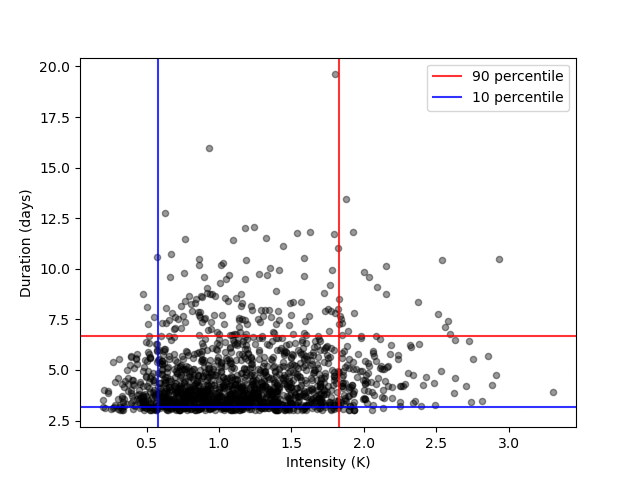

In [3]:
%matplotlib notebook
import seaborn as sns
import scipy.stats
from scipy import interpolate

with gzip.open('/home/scratch/Abel_data/heat_indexv1', 'rb') as f:
    heat_index= pickle.load(f)

int_list=[]
dur_list=[]

for i in range(len(heat_index)):
    int_list.append(heat_index[i][3])
    dur_list.append(heat_index[i][4])

plt.scatter(int_list, dur_list,s=20,color='black',alpha=0.4)
pn,pm=np.quantile(int_list,[0.1,0.9])
plt.axvline(pn,color='blue',alpha=0.8);plt.axvline(pm,color='red',alpha=0.8, label='90 percentile')
pn,pm=np.quantile(dur_list,[0.1,0.9])
plt.axhline(pn,color='blue',alpha=0.8, label='10 percentile');plt.axhline(pm,color='red',alpha=0.8)
plt.xlabel('Intensity (K)')
plt.ylabel('Duration (days)')
plt.legend()

plt.savefig('/home/data/lab_abel/Paper1_plots/fig4.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>


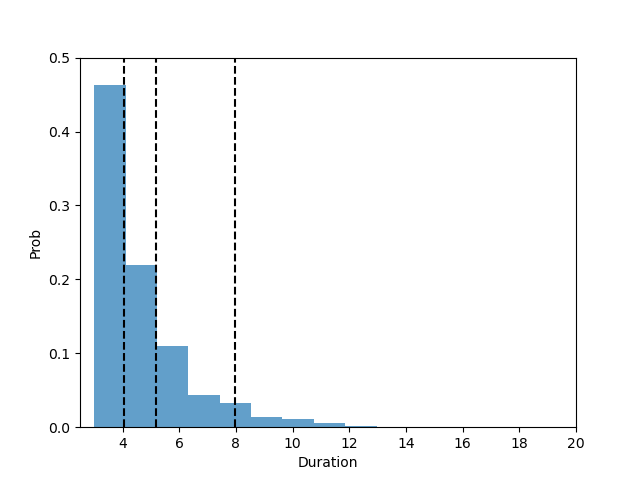

In [22]:
plt.hist(dur_list, bins=15, density=True, alpha=0.7)
plt.xlabel('Duration')
plt.ylabel('Prob')
plt.xlim((2.5,20))
plt.ylim((0,0.5))
ft,sd,td=np.quantile(dur_list,[0.5,0.75,0.95])
plt.axvline(ft,color='black',linestyle='dashed')
plt.axvline(sd,color='black',linestyle='dashed')
plt.axvline(td,color='black',linestyle='dashed')
plt.show()

<IPython.core.display.Javascript object>


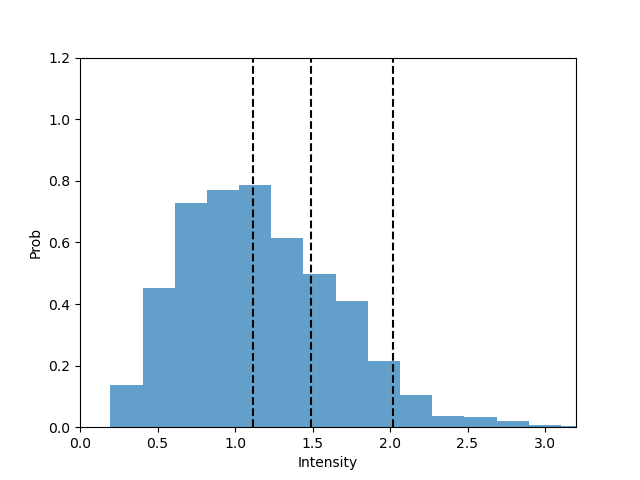

In [32]:
plt.hist(int_list, bins=15, density=True, alpha=0.7)
plt.xlabel('Intensity')
plt.ylabel('Prob')
plt.xlim((0,3.2))
plt.ylim((0,1.2))
ft,sd,td=np.quantile(int_list,[0.5,0.75,0.95])
plt.axvline(ft,color='black',linestyle='dashed')
plt.axvline(sd,color='black',linestyle='dashed')
plt.axvline(td,color='black',linestyle='dashed')
plt.show()